In [121]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# toppra
import toppra as ta
import toppra.constraint as constraint
import toppra.algorithm as algo
import numpy as np
from dataclasses import dataclass
# misc: for plotting and measuring time
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [105]:
# ta.setup_logging() # used in example with v0 != 0

In [122]:
################## DATA CLASSES ########################
@dataclass
class motorValues:
    '''Class for keeping track of important values for each axis's motor.'''
    shaft_dia: float # in cm
    turn_dist: float # in cm
    max_vel:   float # in rad/s
    max_acc:   float # in rad/s^2

In [123]:
# Random waypoints used to obtain a random geometric path. Here,
# we use spline interpolation.
dof = 2   # because we are moving the z-axis independently 
curr_loc = [2.5,  70] # start x and y c0ordinates, say in cm?
end_loc  = [10.0, 6.3]  

x_dist = (end_loc[0]-curr_loc[0]) 
y_dist = (end_loc[1]-curr_loc[1]) 

print("need to move in x:", x_dist, "and in y:", y_dist, "cm")

# imaginary motor values 
X = motorValues(5.5, 0, 9.5, 1.6)
Y = motorValues(9.2, 0, 7.25, 1.8)

need to move in x: 7.5 and in y: -63.7 cm


In [124]:
# calculate displacement at each full 2*pi turn of motor based on motor info
X.turn_dist = 2*np.pi*X.shaft_dia/2 # cm / (2*pi rads) -> circumference
Y.turn_dist = 2*np.pi*Y.shaft_dia/2
print("No. rads in one turn x (cm):", X.turn_dist, ", y (cm):", Y.turn_dist)

# calculate how many radians needed to get the distance from start to finish
x_rads_needed = x_dist / (X.shaft_dia/2)  # (end cm-start cm) / ( turn_dist cm/(2*pi rad))
y_rads_needed = y_dist / (Y.shaft_dia/2)  # percent 

print("rads needed x (rads):", x_rads_needed, ", y (rads):", y_rads_needed)

start_rad = [0, 0]
end_rad   = [x_rads_needed, y_rads_needed]

No. rads in one turn x (cm): 17.27875959474386 , y (cm): 28.902652413026093
rads needed x (rads): 2.727272727272727 , y (rads): -13.847826086956523


In [125]:
way_pts = np.vstack((start_rad,end_rad))
num_waypoints = 2

# np.random.seed(0)
path = ta.SplineInterpolator(np.linspace(0, 1, num_waypoints), way_pts)

In [126]:
# Create velocity bounds, then velocity constraint object
vlim_init = np.array([X.max_vel, Y.max_vel])
vlim = np.vstack((-vlim_init, vlim_init)).T

# # Create acceleration bounds, then acceleration constraint object
alim_init = np.array([X.max_acc, Y.max_acc])
alim = np.vstack((-alim_init, alim_init)).T

pc_vel = constraint.JointVelocityConstraint(vlim)
pc_acc = constraint.JointAccelerationConstraint(
   alim, discretization_scheme=constraint.DiscretizationType.Interpolation)

print(pc_acc)
print(pc_vel)

JointAccelerationConstraint(
    Type: ConstraintType.CanonicalLinear
    Discretization Scheme: DiscretizationType.Interpolation
    Acceleration limit: 
      J1: [-1.6  1.6]
      J2: [-1.8  1.8]
)
JointVelocityConstraint(
    Type: ConstraintType.CanonicalLinear
    Discretization Scheme: DiscretizationType.Collocation
    Velocity limit: 
      J1: [-9.5  9.5]
      J2: [-7.25  7.25]
)


In [127]:
t0 = time.time()
# Setup a parametrization instance, then retime
gridpoints = np.linspace(0, path.duration, 200)
instance = algo.TOPPRA([pc_vel, pc_acc], path, gridpoints=gridpoints, solver_wrapper='seidel')
jnt_traj, aux_traj, int_data = instance.compute_trajectory(0, 0, return_data=True)

print("Parameterization time: {:} secs".format(time.time() - t0))

(('seidel', True), ('hotqpoases', False), ('qpoases', False), ('ecos', True), ('cvxpy', False))
Parameterization time: 0.024070262908935547 secs


<IPython.core.display.Javascript object>


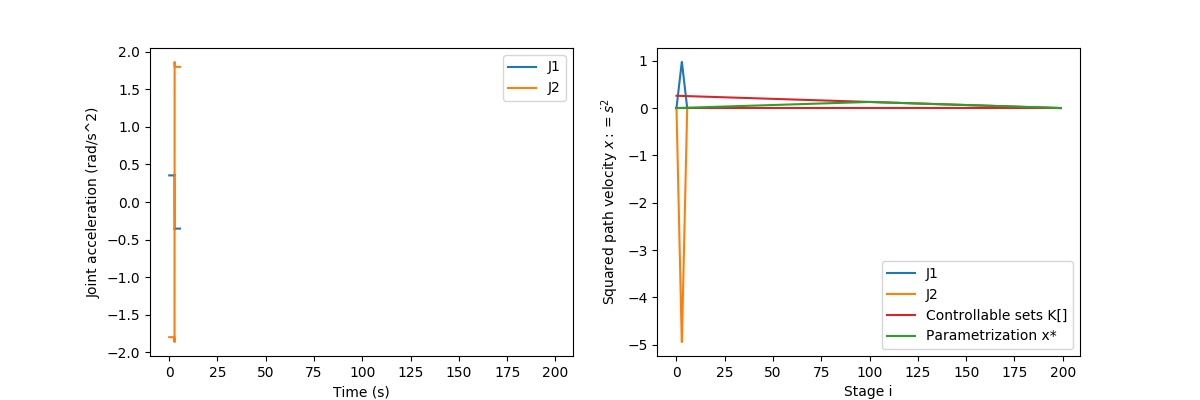

In [128]:
ts_sample = np.linspace(0, jnt_traj.get_duration(), 100)
qdds_sample = jnt_traj.evaldd(ts_sample)
qds_sample = jnt_traj.evald(ts_sample)

fig, axs = plt.subplots(1, 2, sharex=True, figsize=[12, 4])
for i in range(num_waypoints):
    axs[0].plot(ts_sample, qdds_sample[:, i], label="J{:d}".format(i + 1))
    axs[1].plot(ts_sample, qds_sample[:, i], label="J{:d}".format(i + 1))
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Joint acceleration (rad/s^2)")
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Joint velocity (rad/s)")
plt.show()

<IPython.core.display.Javascript object>


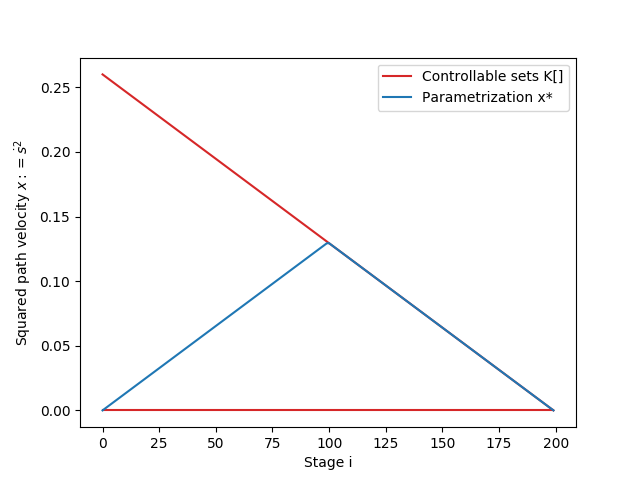

In [130]:
plt.plot(int_data['K'][:, 0], c='C3', label="Controllable sets K[]")
plt.plot(int_data['K'][:, 1], c='C3')
plt.plot(int_data['sd'] ** 2, label="Parametrization x*")
plt.legend()
plt.xlabel("Stage i")
plt.ylabel("Squared path velocity $x:=\dot s^2$")
plt.show()

In [131]:
# to obtain the displacement, use eval
path_sample = jnt_traj.eval(ts_sample) # in rads

<IPython.core.display.Javascript object>


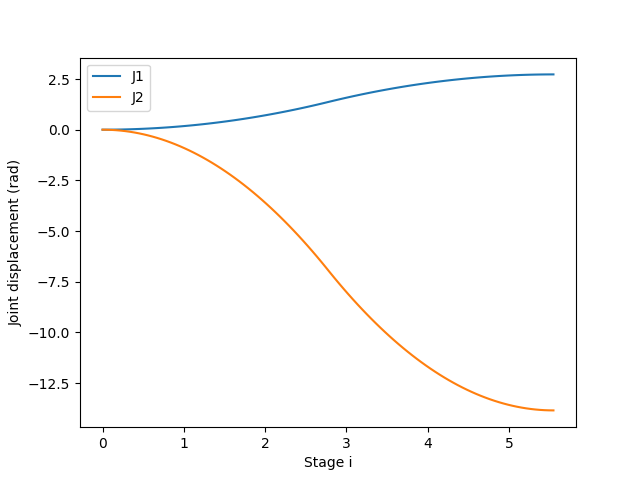

In [132]:
# print the trajectory 
plt.plot(ts_sample, path_sample[:, 0], label="J{:d}".format(0 + 1))
plt.plot(ts_sample, path_sample[:, 1], label="J{:d}".format(1 + 1))

plt.legend()
plt.xlabel("Stage i")
plt.ylabel("Joint displacement (rad)")
plt.show()

In [133]:
path_cm_x = np.array(path_sample[:,0])*(X.turn_dist / (2*np.pi))
path_cm_y = np.array(path_sample[:,1])*(Y.turn_dist / (2*np.pi))

<IPython.core.display.Javascript object>


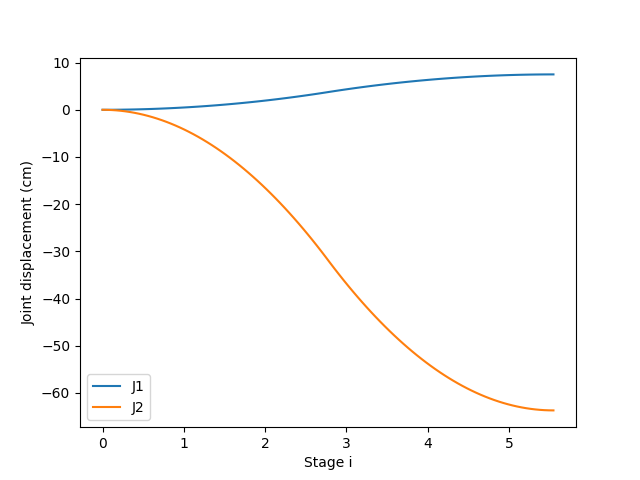

In [134]:
# print the trajectory 
plt.plot(ts_sample, path_cm_x, label="J{:d}".format(0 + 1))
plt.plot(ts_sample, path_cm_y, label="J{:d}".format(1 + 1))

plt.legend()
plt.xlabel("Stage i")
plt.ylabel("Joint displacement (cm)")
plt.show()

<IPython.core.display.Javascript object>


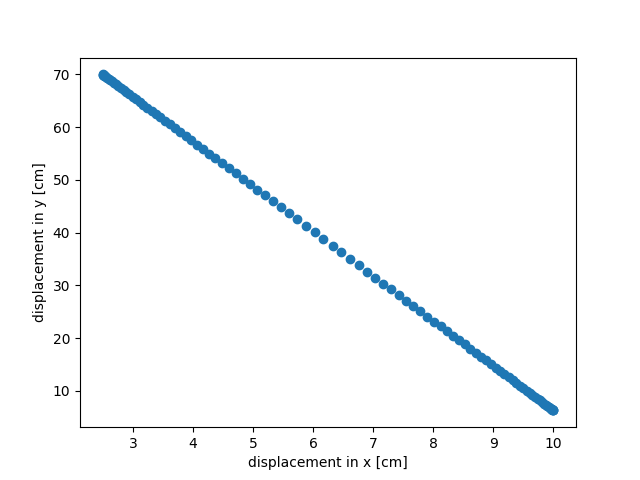

In [135]:
# calculate and plot the path the manipulator will take
x_path = np.array(path_cm_x) + curr_loc[0]
y_path = np.array(path_cm_y) + curr_loc[1]

plt.scatter(x_path, y_path)
plt.xlabel("displacement in x [cm]")
plt.ylabel("displacement in y [cm]")
plt.show()

<IPython.core.display.Javascript object>


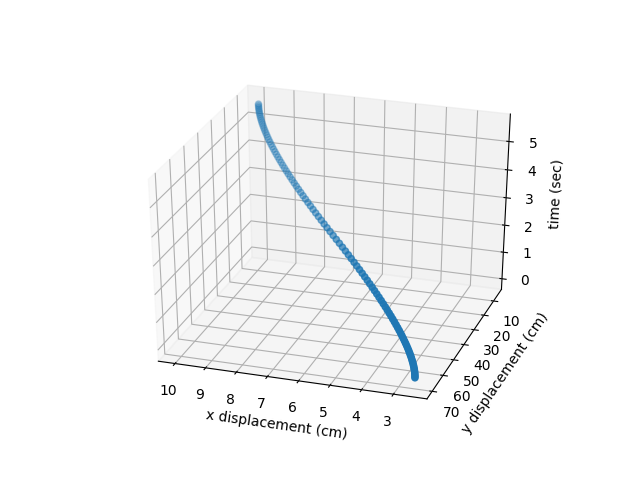

In [136]:
# calculate and plot the path the manipulator will take
x_path = np.array(path_cm_x) + curr_loc[0]
y_path = np.array(path_cm_y) + curr_loc[1]

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(x_path, y_path, ts_sample)

ax.set_xlabel('x displacement (cm)')
ax.set_ylabel('y displacement (cm)')
ax.set_zlabel('time (sec)')

plt.show()